MediaPipe Pose is a ML solution for body pose estimation/tracking, inferring 33 3D landmarks (see image below) on the whole body from RGB image/video.
The solution utilizes a two-step detector-tracker ML pipeline. Using a detector, the pipeline first locates the person within the frame (region of interest - ROI).

 The tracker subsequently predicts the pose landmarks within the ROI using the ROI-cropped frame as input.
 
  For video use cases the detector is invoked only as needed, i.e., for the very first frame and when the tracker could no longer identify body person presence in the previous frame. 
  
  For other frames the pipeline simply derives the ROI from the previous frame’s pose landmarks.

NB: Optionally, MediaPipe Pose can predicts a full-body segmentation mask represented as a two-class segmentation (human or background),

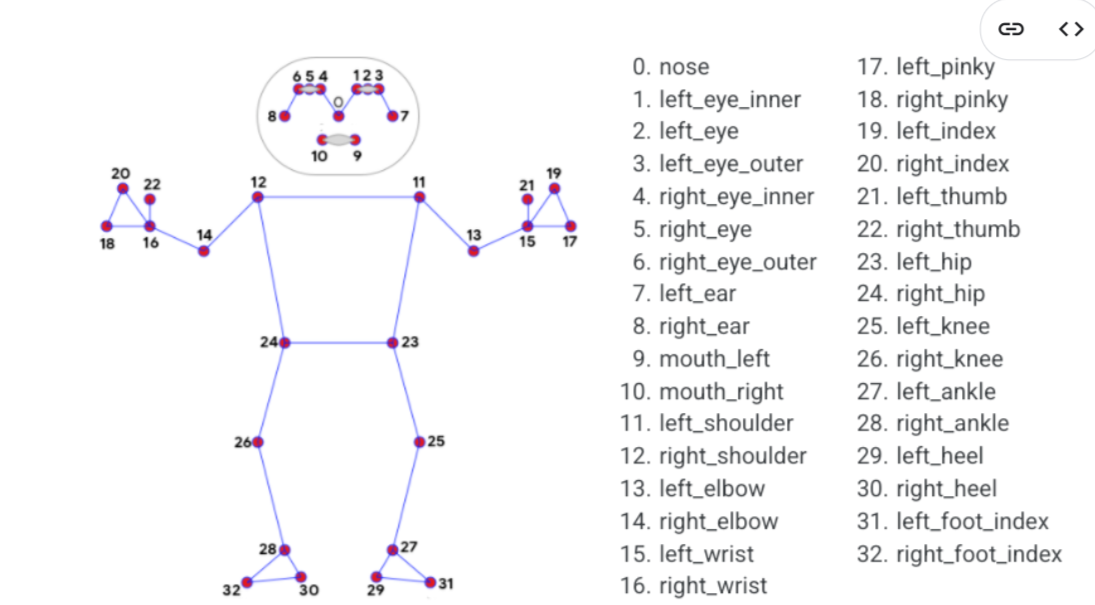

Installing the dependencies 


In [1]:
pip install mediapipe

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2 #to read and process images
import matplotlib.pyplot as plt #to show resultant images 
import mediapipe as mp

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose
# Setting up the Pose model for images.
pose_img = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)
# Setting up the Pose model for videos.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, 
                          min_tracking_confidence=0.5, model_complexity=1)

# Initializing mediapipe drawing class to draw landmarks on specified image.
mp_drawing = mp.solutions.drawing_utils


In [3]:
def estimPose_img(input_file, pose=pose_img, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                   thickness=20, circle_r=10, display=True):
    
    # Read the input image
    if isinstance(input_file, str) :
        input_img = cv2.imread(input_file)
    else :
        input_img = input_file
    
    # Create a copy of the input image
    output_img = input_img.copy()
    
    # Convert the image from BGR into RGB format.
    RGB_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(RGB_img)
    
    # Retrieve the height and width of the input image.
    height, width, _ = input_img.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(output_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                  mp_drawing.DrawingSpec(landmarks_c, thickness, circle_r),
                                  mp_drawing.DrawingSpec(connection_c, thickness, circle_r))
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if we want to display.
    if display:
        # Display the original input image and the resulting image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(input_img[:,:,::-1]);plt.title("Original image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_img[:,:,::-1]);plt.title("Output image");plt.axis('off');
        
        # Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Just get output_img and landmarks
    else:
        # Return the output image and the found landmarks.
        return output_img, landmarks


In [4]:
def estimPose_video(input_file, pose_video=pose_video, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                 thickness=5, circle_r=5, display=True, nrows_frames=4, ncols_frames=3):
    
    # Initialize the VideoCapture object to read from a video stored in the disk.
    video = cv2.VideoCapture(input_file)
    
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    
    for i in range(total_frames):
        # Read a frame.
        ok, frame = video.read()
    
        # Check if frame is not read properly.
        if not ok:
            # Break the loop.
            break
        
        # Get the width and height of the frame
        frame_height, frame_width, _ =  frame.shape
        # Resize the frame while keeping the aspect ratio.
        frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
        frame, _ = estimPose_img(frame, pose_video, landmarks_c, connection_c, thickness, 
                              circle_r, display=False)
    
        frames.append(frame)
    
    if display :
        fig, axarr = plt.subplots(nrows_frames,ncols_frames,figsize=[15, 15])
        k=0
        for i in range(nrows_frames):
            for j in range(ncols_frames):
                axarr[i,j].imshow(frames[k][:,:,::-1]);axarr[i,j].axis('off')
                k+=1
    else:
        return frames

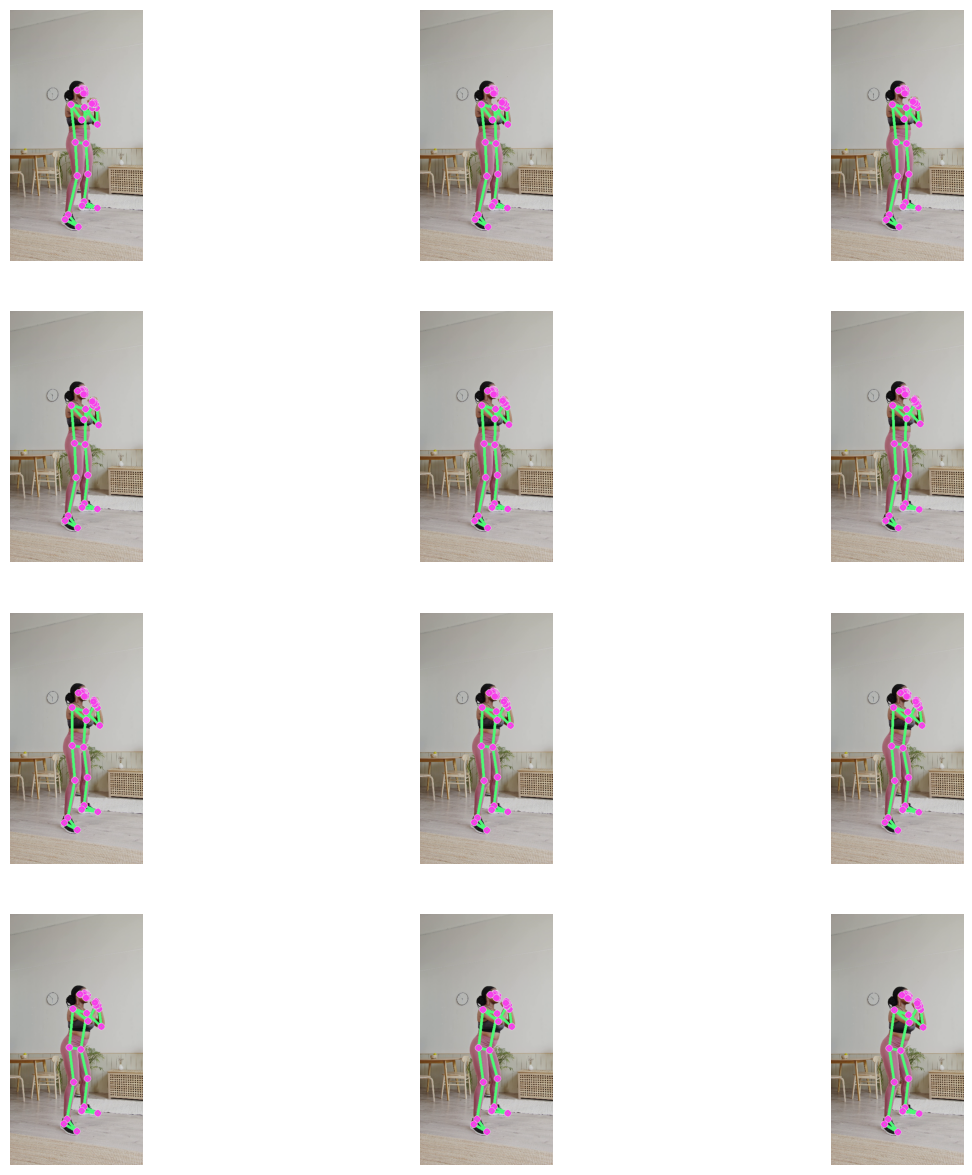

In [5]:
# Run the function with the updated file path
estimPose_video(input_file="D:\\VIT\\Aws project\\video2.mp4")


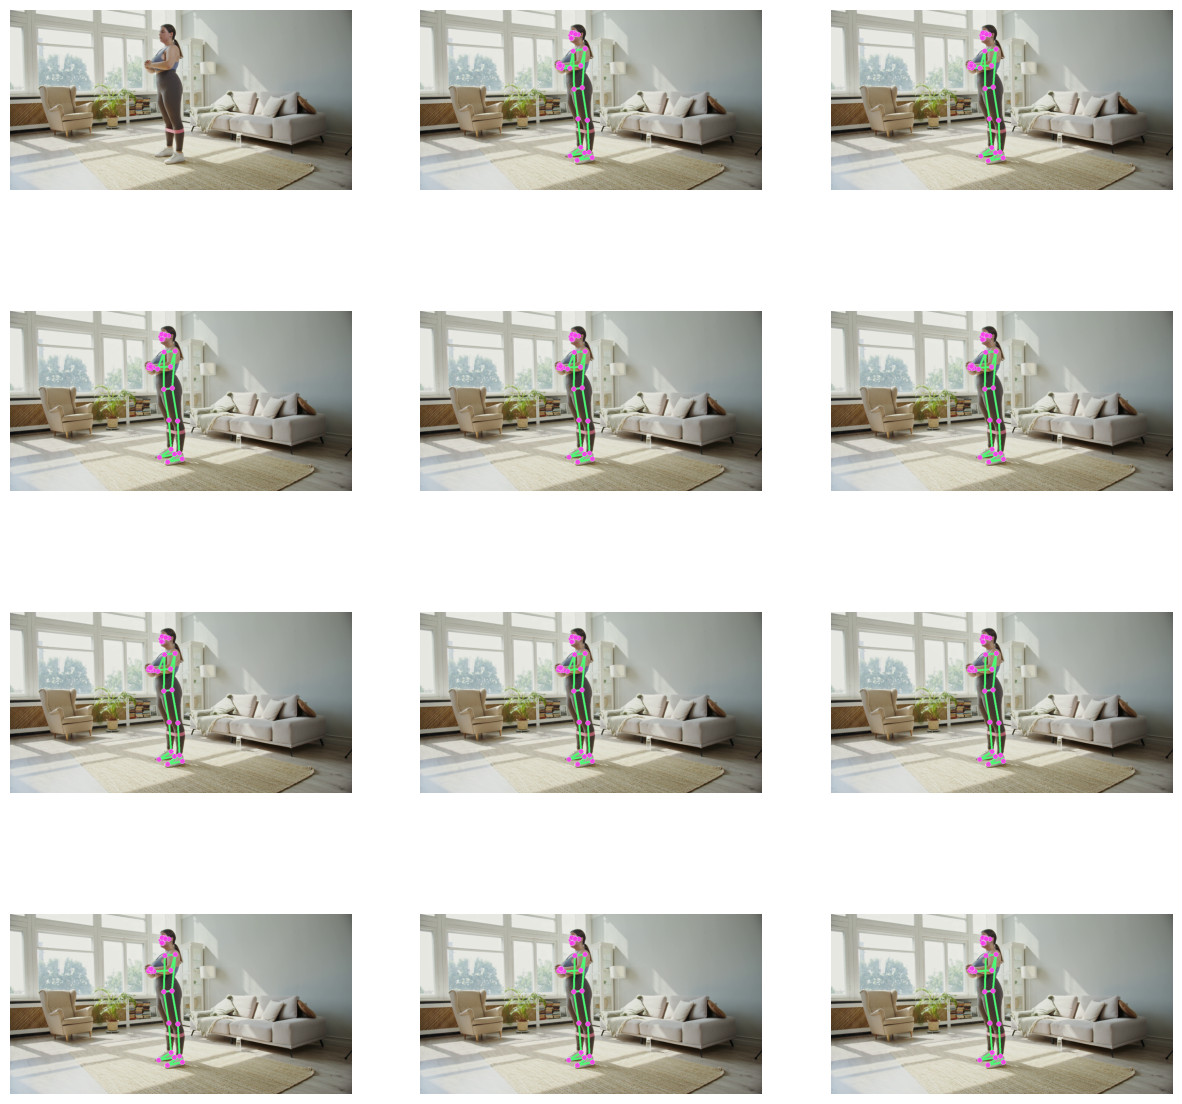

In [6]:
# Run the function with the updated file path
estimPose_video(input_file="D:\\VIT\\Aws project\\video1.mp4")


In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def calculate_angle(point1, point2, point3):
    """Calculate the angle between three points."""
    p1 = np.array(point1)
    p2 = np.array(point2)
    p3 = np.array(point3)
    
    v1 = p1 - p2
    v2 = p3 - p2
    
    angle = np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)))
    
    return angle

def estimPose_video(input_file, pose_video=pose_video, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                    thickness=5, circle_r=5, display=True, nrows_frames=4, ncols_frames=3):
    
    # Initialize the VideoCapture object to read from a video stored on disk.
    video = cv2.VideoCapture(input_file)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    # Calculate interval to sample frames evenly across the video duration.
    frame_interval = max(1, total_frames // (nrows_frames * ncols_frames))

    for i in range(0, total_frames, frame_interval):
        # Set the position of the video to the specified frame.
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        
        # Read a frame.
        ok, frame = video.read()
        if not ok:
            break  # Break the loop if frame is not read properly.

        # Resize the frame while keeping the aspect ratio.
        frame_height, frame_width, _ = frame.shape
        frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
        
        # Apply pose estimation.
        frame, landmarks = estimPose_img(frame, pose_video, landmarks_c, connection_c, thickness, circle_r, display=False)

        # Initialize posture evaluation
        posture_correct = True
        label = "Correct Posture"  # Default label

        # Check if landmarks are available
        if landmarks and len(landmarks) > 0:
            left_knee = landmarks[27]  # Example index for left knee
            right_knee = landmarks[28]  # Example index for right knee
            left_hip = landmarks[25]  # Example index for left hip
            right_hip = landmarks[26]  # Example index for right hip
            chest = landmarks[23]  # Example index for chest

            # Calculate angle between knees
            knee_angle = calculate_angle(left_knee, left_hip, right_knee)  # Adjusted for the angle between knees

            # Check knee angle (should be greater than 90 degrees for correct posture)
            if knee_angle <= 90:
                posture_correct = False
                label = "Wrong Posture"

        # Set text color based on posture evaluation
        text_color = (0, 255, 0) if posture_correct else (0, 0, 255)  # Dark green for correct, red for wrong

        # Annotate the frame with the posture evaluation
        cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 2)

        frames.append(frame)
    
    # Display frames in a grid if display is True
    if display:
        fig, axarr = plt.subplots(nrows_frames, ncols_frames, figsize=[15, 15])
        k = 0
        for i in range(nrows_frames):
            for j in range(ncols_frames):
                if k < len(frames):
                    axarr[i, j].imshow(frames[k][:, :, ::-1])
                else:
                    axarr[i, j].axis('off')  # Hide unused subplots if not enough frames.
                axarr[i, j].axis('off')
                k += 1
    else:
        return frames


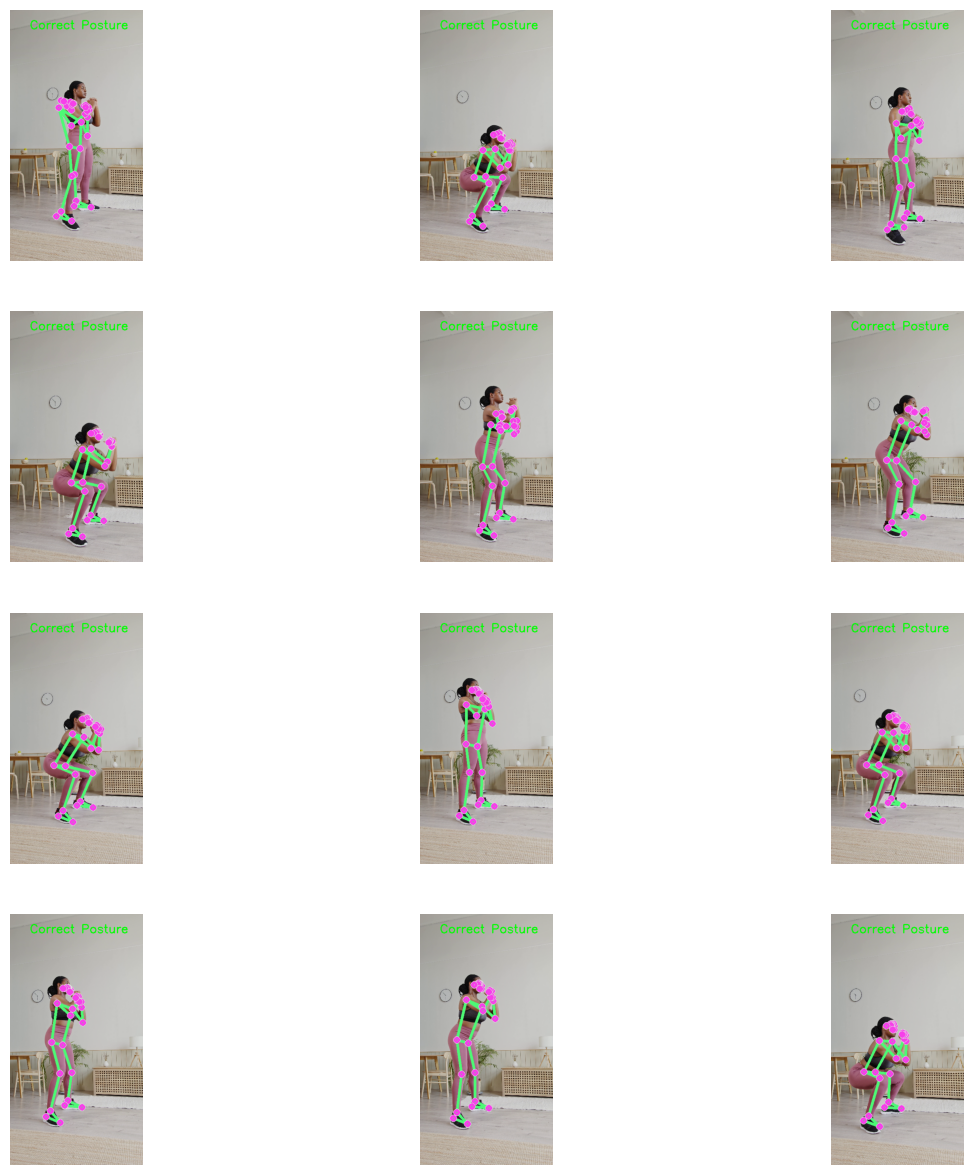

In [13]:
# Run the function with the updated file path
estimPose_video(input_file="D:\\VIT\\Aws project\\video2.mp4")
